In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# images to tensors
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# loading CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./Datasets/6_CNN_Data/CIFAR10', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./Datasets/6_CNN_Data/CIFAR10', train=False, download=True, transform=transform)

batch_size = 32  # batch size
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# define CNN model
class CIFAR(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(8192, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.flat(x)
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        x = self.fc4(x)
        return x

# Move model to GPU
model = CIFAR().to(device)

loss_fn = nn.CrossEntropyLoss()  # Cross-Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # choose SGD optim

n_epochs = 50  # epochs
for epoch in range(n_epochs):
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        y_pred = model(inputs)  # passing data through model
        loss = loss_fn(y_pred, labels)  # loss evaluation
        optimizer.zero_grad()  # gradient reset
        loss.backward()  # backpropagation
        optimizer.step()

    acc = 0
    count = 0
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        y_pred = model(inputs)  # passing data through model
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()  # precision evaluation
        count += len(labels)
    acc /= count
    print("Epoch %d: accuracy %.2f%%" % (epoch, acc * 100))  # precision for given epoch
torch.save(model.state_dict(), "./Models/CIFAR10_CNN_model.pth")

Files already downloaded and verified
Files already downloaded and verified
Epoch 0: accuracy 31.93%
Epoch 1: accuracy 42.29%
Epoch 2: accuracy 45.76%
Epoch 3: accuracy 49.39%
Epoch 4: accuracy 51.52%
Epoch 5: accuracy 52.85%
Epoch 6: accuracy 54.58%
Epoch 7: accuracy 56.27%
Epoch 8: accuracy 57.10%
Epoch 9: accuracy 59.06%
Epoch 10: accuracy 59.89%
Epoch 11: accuracy 62.09%
Epoch 12: accuracy 62.13%
Epoch 13: accuracy 64.73%
Epoch 14: accuracy 65.15%
Epoch 15: accuracy 67.31%
Epoch 16: accuracy 68.79%
Epoch 17: accuracy 69.74%
Epoch 18: accuracy 71.43%
Epoch 19: accuracy 72.13%
Epoch 20: accuracy 74.38%
Epoch 21: accuracy 75.98%
Epoch 22: accuracy 77.01%
Epoch 23: accuracy 78.04%
Epoch 24: accuracy 79.30%
Epoch 25: accuracy 80.32%
Epoch 26: accuracy 80.82%
Epoch 27: accuracy 82.76%
Epoch 28: accuracy 83.69%
Epoch 29: accuracy 85.08%
Epoch 30: accuracy 85.45%
Epoch 31: accuracy 86.10%
Epoch 32: accuracy 87.04%
Epoch 33: accuracy 87.32%
Epoch 34: accuracy 88.54%
Epoch 35: accuracy 88.74

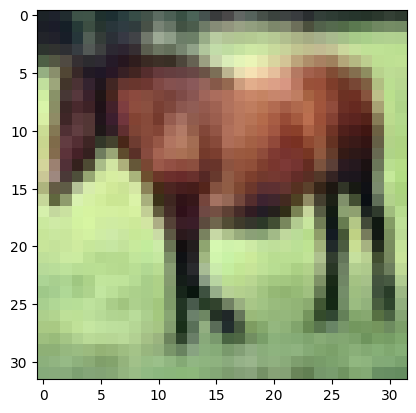

In [24]:
import matplotlib.pyplot as plt

plt.imshow(trainset.data[7])
plt.show()

In [25]:
X = torch.tensor([trainset.data[7]], dtype=torch.float32).permute(0, 3, 1, 2).to(device)

# evaluation mode (doesntevaluate gradients)
model.eval()

# predictions withoutgradients
with torch.no_grad():
    feature_maps = model.conv1(X)

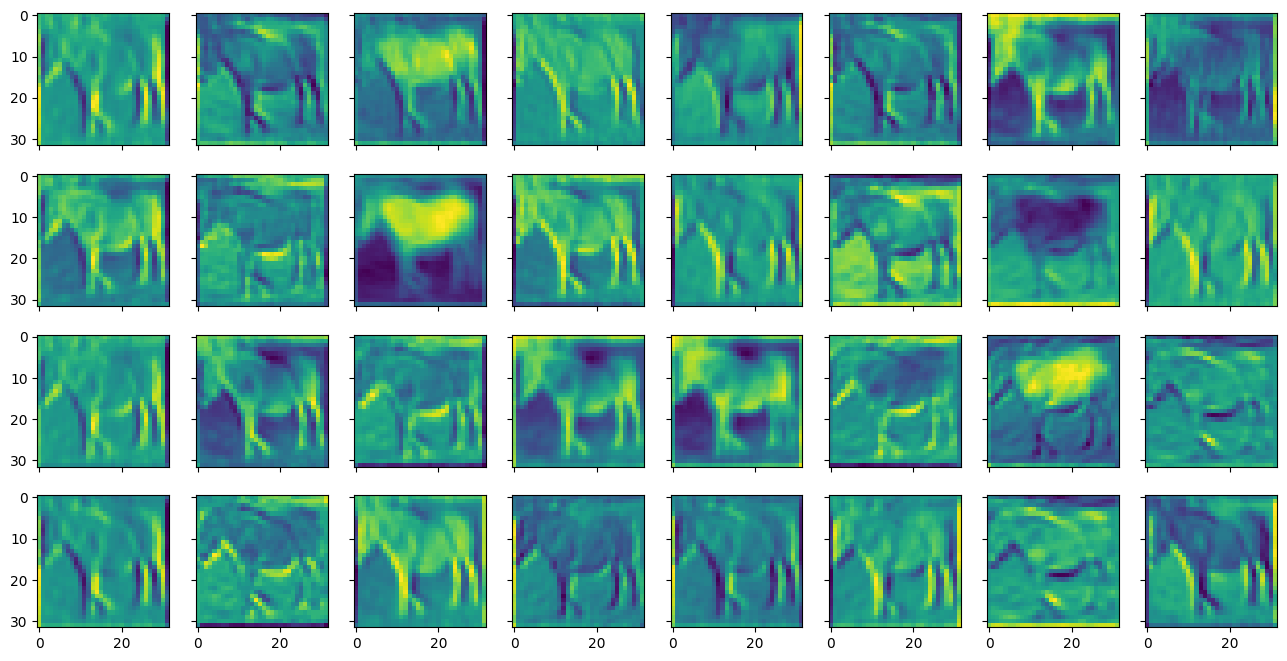

In [26]:
# Creating a subplot grid of size 4x8 to display feature maps
fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(16, 8))

# Move feature maps tensor to CPU
feature_maps_cpu = feature_maps.cpu()

# Plotting each feature map
for i in range(32):
    row, col = i // 8, i % 8  # Coordinates in the subplot grid
    ax[row][col].imshow(feature_maps_cpu[0, i].cpu().numpy())  # Convert CUDA tensor to NumPy array
plt.show()

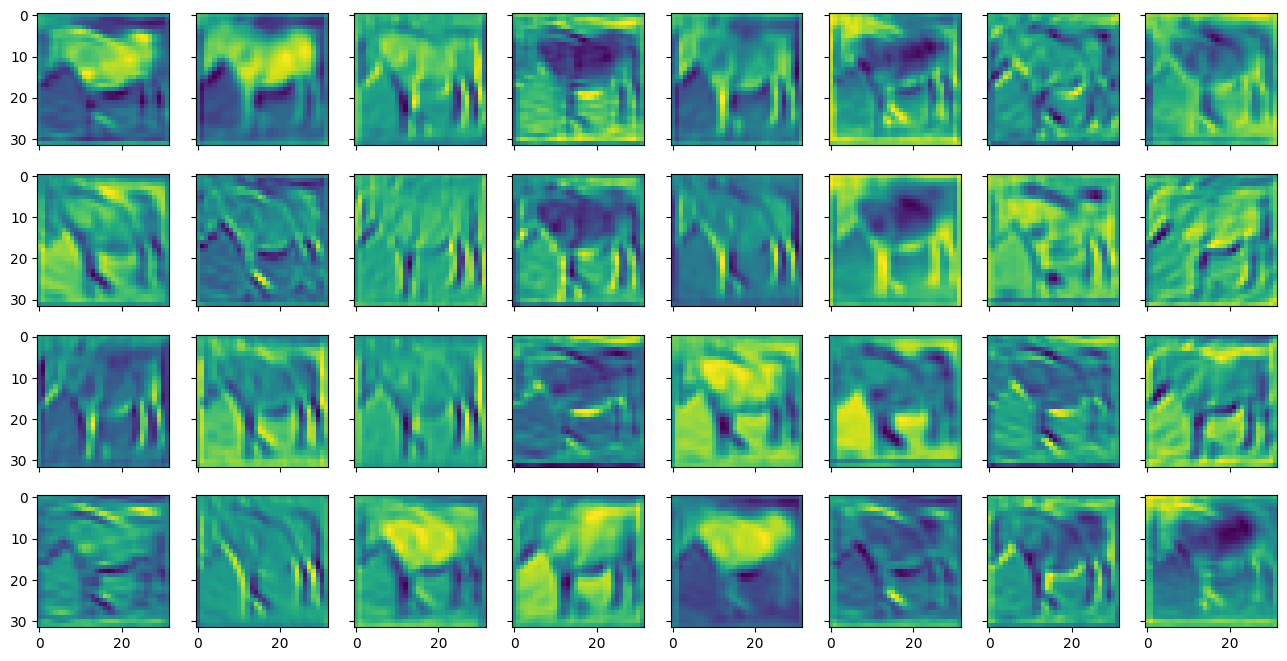

In [27]:
# Creating tensor X with the first training image, reshaping, and permuting axes
X = torch.tensor([trainset.data[7]], dtype=torch.float32).permute(0, 3, 1, 2).to(device)
model.eval()

# Generating feature maps for the image
with torch.no_grad():
    feature_maps = model.act1(model.conv1(X))  # Calculating feature maps after the first convolutional layer
    feature_maps = model.drop1(feature_maps)  # Passing through the dropout layer
    feature_maps = model.conv2(feature_maps)  # Calculating feature maps after the second convolutional layer

# Move feature maps tensor to CPU
feature_maps_cpu = feature_maps.cpu()

# Creating a subplot grid of size 4x8 to display feature maps
fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(16, 8))

# Plotting each feature map
for i in range(32):
    row, col = i // 8, i % 8  # Coordinates in the subplot grid
    ax[row][col].imshow(feature_maps_cpu[0, i].cpu().numpy())  # Convert CUDA tensor to NumPy array
plt.show()

## Emotion Classification Based on Facial Images

**Goal:** Create a CNN model that recognizes emotions in facial images.

**Steps:**
1. Familiarize yourself with the structure of the FER-2013 directory.
2. Load the dataset (FER-2013 directory).
3. Perform basic data analysis and visualization.
4. Prepare data for the learning process - normalization, augmentation, splitting into training and testing sets (according to the directory).
5. Build a simple CNN model that includes at least two convolutional layers.
6. Train the model, monitoring its accuracy and loss.
7. Evaluate the effectiveness of the model on the test data.

In [29]:
import torch  
import torch.nn as nn  
import torch.optim as optim  
import torchvision  
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dir = "./Datasets/6_CNN_Data/FER-2013/train"
test_dir = "./Datasets/6_CNN_Data/FER-2013/test"  
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)

In [30]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [31]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 6 * 6, 256)  
        self.fc2 = nn.Linear(256, 7)  

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        
        
        x = x.view(-1, 128 * 6 * 6)  
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [32]:
model = SimpleCNN()

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


n_epochs = 50

for epoch in range(n_epochs):
    model.train()  
    total_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  
        outputs = model(inputs)  
        loss = loss_fn(outputs, labels)  
        loss.backward()  
        optimizer.step()  

        total_loss += loss.item() * inputs.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {avg_loss:.4f}")
torch.save(model.state_dict(), "./Models/FER-13_CNN_model.pth")

Epoch 1/50, Training Loss: 1.4709
Epoch 2/50, Training Loss: 1.3952
Epoch 3/50, Training Loss: 1.3458
Epoch 4/50, Training Loss: 1.3102
Epoch 5/50, Training Loss: 1.2728
Epoch 6/50, Training Loss: 1.2550
Epoch 7/50, Training Loss: 1.2275
Epoch 8/50, Training Loss: 1.2107
Epoch 9/50, Training Loss: 1.1857
Epoch 10/50, Training Loss: 1.1719
Epoch 11/50, Training Loss: 1.1533
Epoch 12/50, Training Loss: 1.1347
Epoch 13/50, Training Loss: 1.1175
Epoch 14/50, Training Loss: 1.1048
Epoch 15/50, Training Loss: 1.0907
Epoch 16/50, Training Loss: 1.0740
Epoch 17/50, Training Loss: 1.0680
Epoch 18/50, Training Loss: 1.0526
Epoch 19/50, Training Loss: 1.0373
Epoch 20/50, Training Loss: 1.0330
Epoch 21/50, Training Loss: 1.0232
Epoch 22/50, Training Loss: 1.0024
Epoch 23/50, Training Loss: 0.9997
Epoch 24/50, Training Loss: 0.9931
Epoch 25/50, Training Loss: 0.9860
Epoch 26/50, Training Loss: 0.9734
Epoch 27/50, Training Loss: 0.9590
Epoch 28/50, Training Loss: 0.9467
Epoch 29/50, Training Loss: 0

In [35]:
model.eval()  
total_loss = 0
correct_predictions = 0

with torch.no_grad():  
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()

avg_loss = total_loss / len(test_loader.dataset)
accuracy = correct_predictions / len(test_loader.dataset)
print(f"Testing Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


Testing Loss: 1.1237, Accuracy: 0.5868
